# Header

In [21]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import healpy as hp

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

nside = 2048
lmax = 2048
ll = np.arange(0,lmax,1)
scale_ps = ll*(ll+1)/(2*np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_l \/ [\mu K^2]$'

# Choose your dataset

In [22]:
from lerepi.data.dc08 import data_08d as sims_if
from lerepi.params.s08 import s08d as parfile
from lerepi.survey_config.dc08 import sc_08d as sc

sims = sims_if.ILC_May2022('00')

In [8]:
import pickle
import numpy as np
np.load('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_noOBD/ivfsOBD/filt_hash.pk', allow_pickle=True)

{'cinv_t': {'lmax': 3000,
  'nside': 2048,
  'cltt': '325957a25492e6884b8fc4f81e0e9ced87c0f45d',
  'transf': 'ff72f4f574e81e8849afe65b8b56ce2faba66a8a',
  'ninv': ['/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_noOBD/itvmap.fits'],
  'marge_monopole': True,
  'marge_dipole': True,
  'marge_maps': []},
 'cinv_p': {'lmax': 3000,
  'nside': 2048,
  'clee': 'd66432d129ce54bc40a0734abfac5af27ac8b6e4',
  'cleb': '1489f923c4dca729178b3e3233458550d8dddf29',
  'clbb': '0e94113a61737d3b7e204c40000a94a4d5a46ddf',
  'transf': 'ff72f4f574e81e8849afe65b8b56ce2faba66a8a',
  'ninv': [['/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_noOBD/ipvmap.fits']]},
 'sim_lib': {'rhits': True,
  'sim_lib': 'cmbs4_08b_ILC_00',
  'units': 1000000.0,
  'path2sim0': '/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08d.00_umilta_220502/cmbs4_08d00_cmb_b02_ellmin30_ellmax4050_map_2048_0000.fits'}}

In [23]:
def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

In [12]:
lonra = [0,60]
latra = [-60, -20]

In [26]:
from plancklens.utils import alm2rlm, rlm2alm, clhash
from itercurv.remapping import cachers
import os

def load_plms(lib_dir, itmax):
    lib_dir = os.path.abspath(lib_dir)
    cacher = cachers.cacher_npy(lib_dir)
    pth = os.path.join(lib_dir, 'phi_plm_it000')
    sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
    rlm = alm2rlm(cacher.load(pth))
    ret = [] if 0 != itmax[0] else [rlm2alm(rlm)]
    for it in itmax:
        for i in range(it):
            rlm += cacher.load(sk_fname(i))
            if (i + 1) == it:
                ret.append(rlm2alm(rlm))
                print(it, ' appended')
    return ret
plm = load_plms('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_nozboundslen/iterator_p_p_0000_OBD/', [0,1,2,3,4])
# plm = load_plms('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_noOBD'+'/iterator_p_p_%04d_OBD'%0, [0,1,2])

# plmMAP = load_plms(parfile.TEMP + '/iterator_p_p_%04d_OBD'%0, 4)

1  appended
2  appended
3  appended
4  appended


Text(0.5, 1.0, 'Lensing potential')

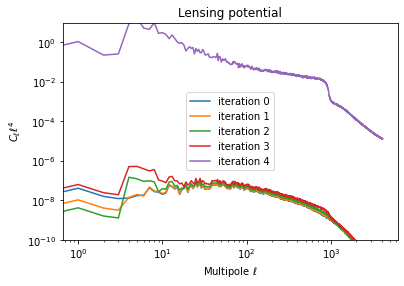

In [38]:
for pi, p in enumerate(plm):
    plt.plot(np.arange(4097)**4*hp.alm2cl(p), label='iteration {}'.format(pi))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-10,1e1)
plt.xlabel('Multipole $\ell$')
plt.ylabel('$C_{\ell}\ell^4$')
plt.title('Lensing potential')

(1e-10, 1e-06)

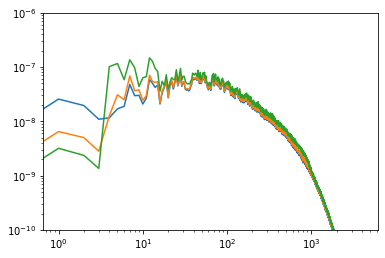

In [11]:
for p in plm:
    plt.plot(np.arange(4097)**4*hp.alm2cl(p))
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10,1e-6)

2.5176508

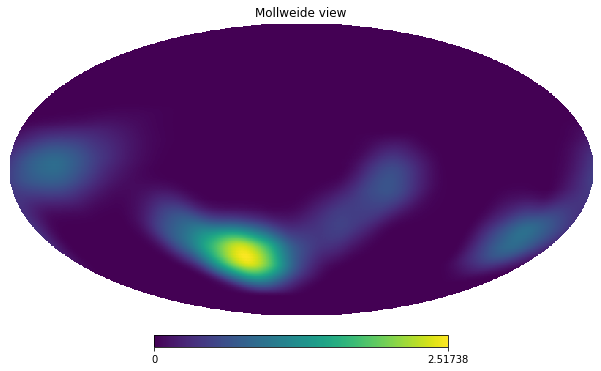

In [53]:
ipvmap = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_nozbounds'+'/ipvmap.fits')
hp.mollview(ipvmap)
print(np.max(ipvmap))

nlev_p = 0.59
# rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/08d/rhits/n2048.fits')) #TODO this should come from survey_conf
rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08d.00_umilta_220502/ILC_mask_08d_smooth_30arcmin.fits')) #TODO this should come from survey_conf
pixlev = nlev_p / (np.sqrt(hp.nside2pixarea(2048, degrees=True)) * 60.)
print("Pmap center pixel pol noise level: %.2f"%(pixlev * np.sqrt(hp.nside2pixarea(nside, degrees=True)) * 60.))
ivmap2 = 1./ pixlev ** 2 * rhits

In [30]:
pmaps = [hp.alm2map(p, nside=2048) for p in plm]
pmaps_bp = [hp.alm2map(bandpass_alms(p,30,200), nside=2048) for p in plm]
# pmaps_bp_low = [hp.alm2map(bandpass_alms(p,2,20), nside=2048) for p in plm]

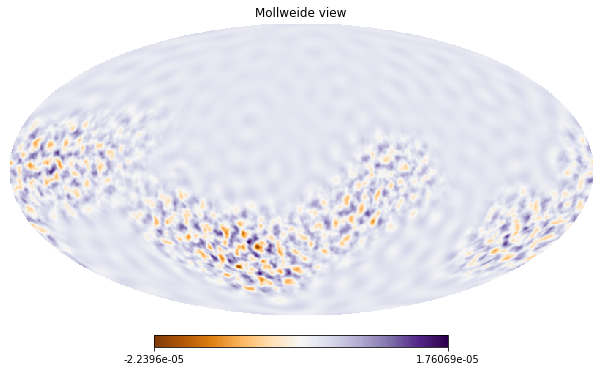

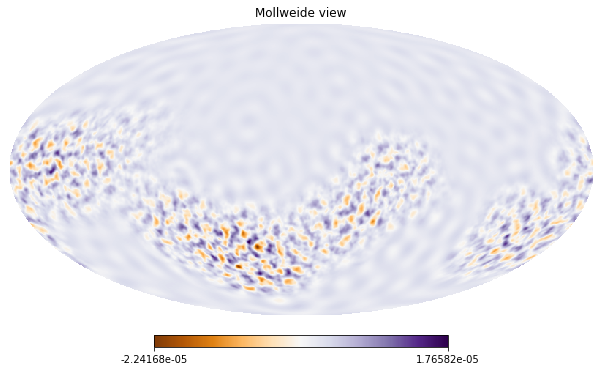

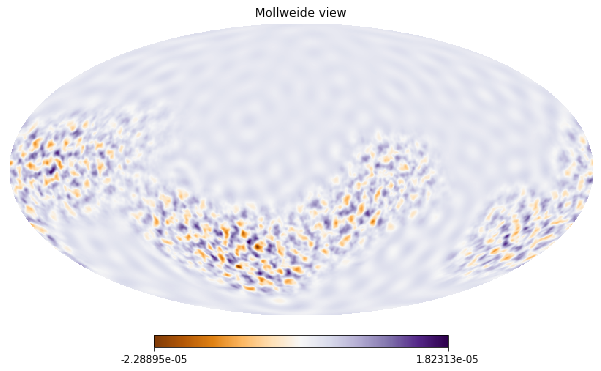

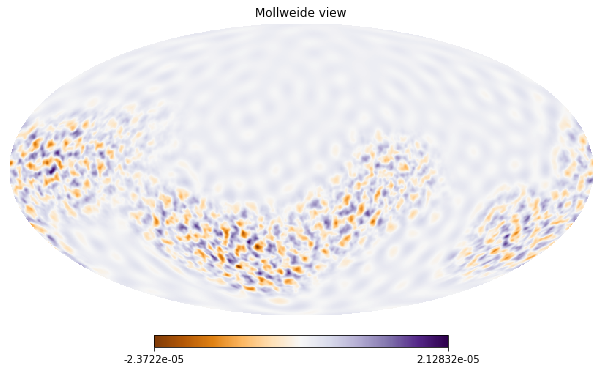

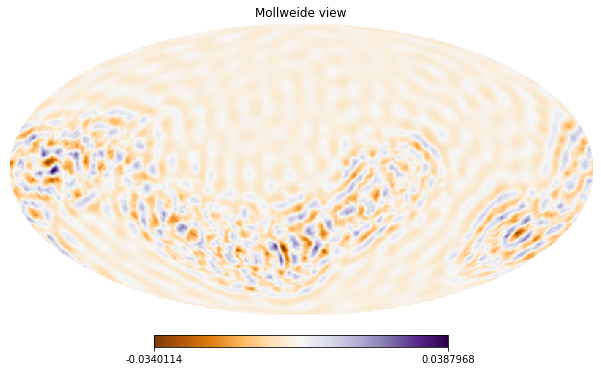

In [31]:
for pm in pmaps_bp:
    # hp.cartview(pm, lonra=lonra, latra=latra, cmap='PuOr')
    hp.mollview(pm, cmap='PuOr')

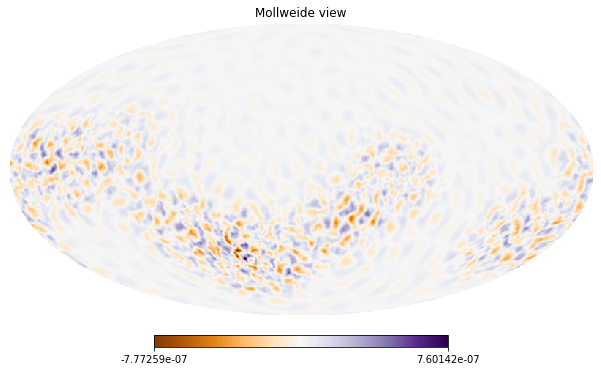

In [20]:
hp.mollview(pmaps_bp[1]-pmaps_bp[0], cmap='PuOr')

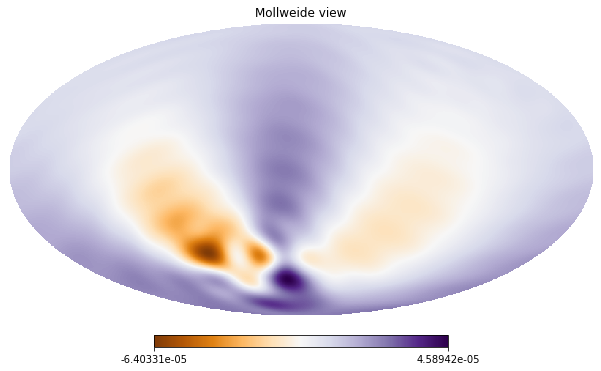

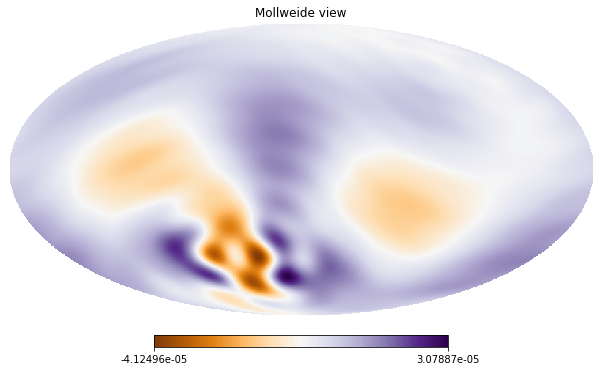

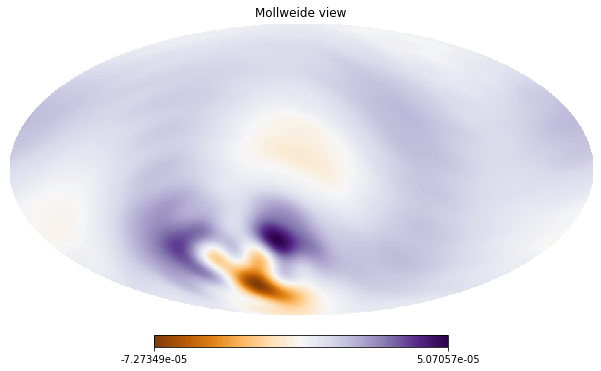

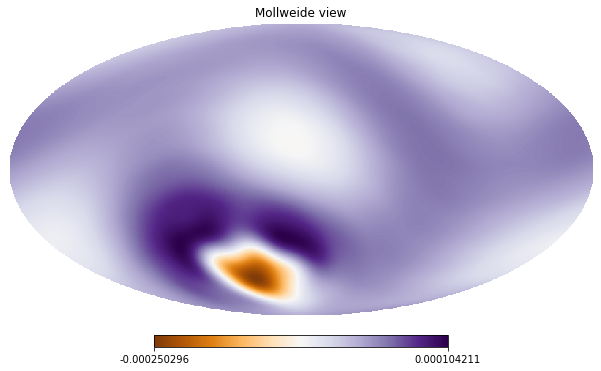

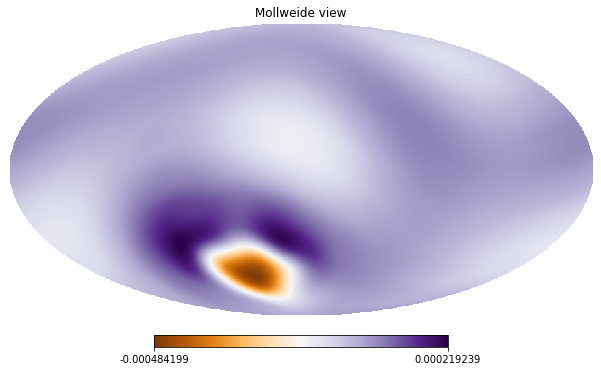

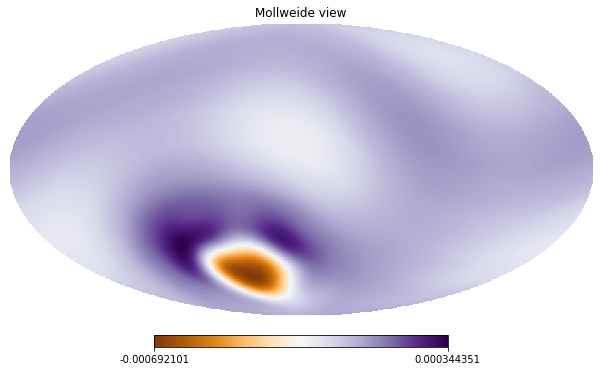

In [39]:
for pmi, (pm, pm_bp) in enumerate(zip(pmaps, pmaps_bp_low)):
    # hp.mollview(pm*np.where(sc.rhits<0.01,0,1), cmap='PuOr')
    hp.mollview(pm, fig=pmi, cmap='PuOr', alpha=0.5*np.ones_like(pm))
    hp.mollview(pm_bp, fig=pmi, cmap='PuOr')#, rot=[0,90,0])#alpha=0.5*np.ones_like(pm))

# Check deflection field

In [28]:
bwd_tht = np.load('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_noOBD/iterator_p_p_0000_OBD/ffi_p_it2/bwd_tht_band00.npy')
bwd_tht.shape

(41266048,)

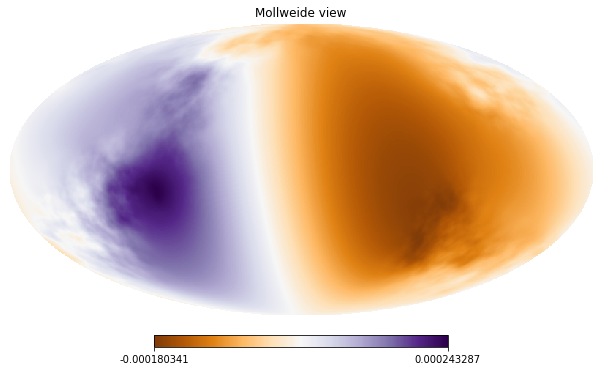

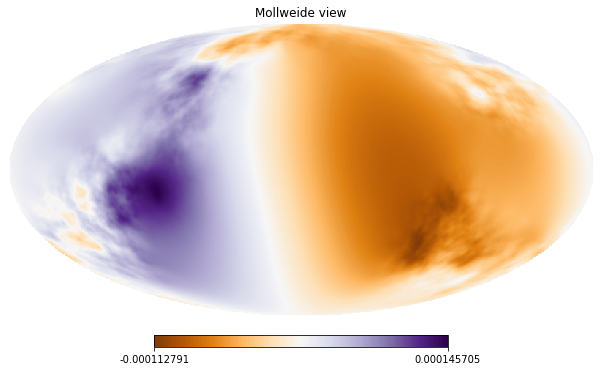

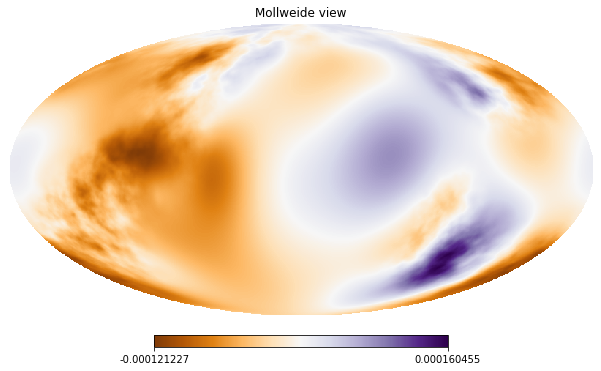

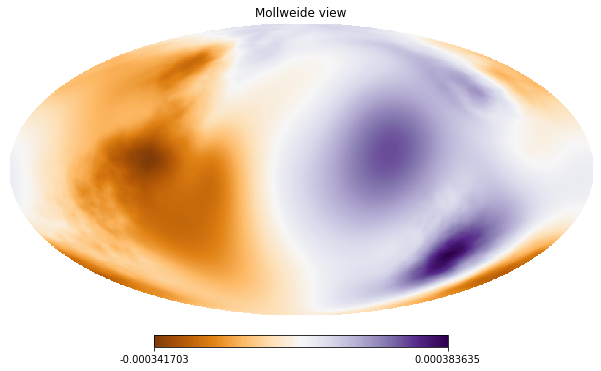

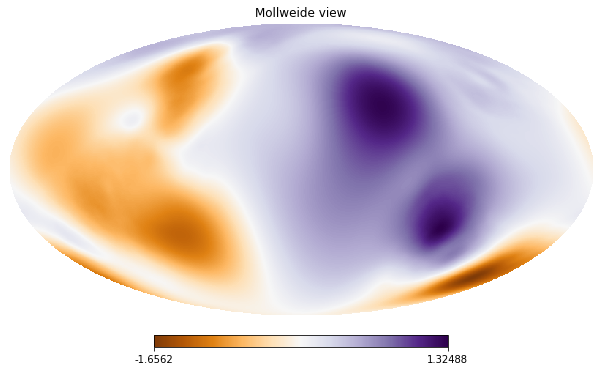

In [42]:
for pm in pmaps:
    # hp.mollview(pm*np.where(sc.rhits<0.01,0,1), cmap='PuOr')
    hp.mollview(pm, cmap='PuOr', rot=[0,90,0])

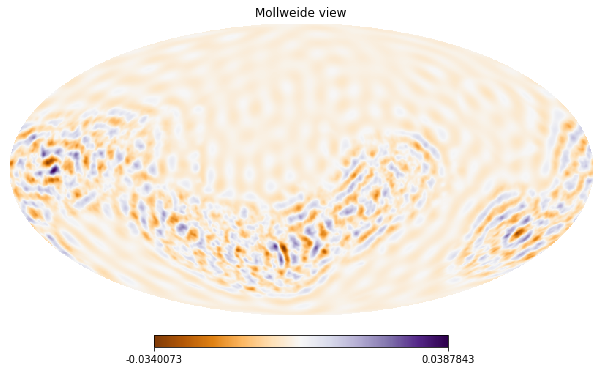

In [34]:
hp.mollview(pmaps_bp[-1]-pmaps_bp[0], cmap='PuOr')

# Load $E^{WF}$s

In [57]:
simid = 0
ewf = parfile.ivfs.get_sim_emliklm(simid)
# ivfs_OBD.get_sim_bmliklm(simid)

In [58]:
ewf.shape

(4504501,)

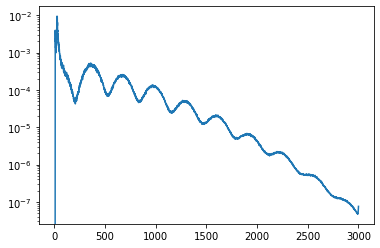

In [59]:
plt.plot(hp.alm2cl(ewf))
plt.yscale('log')

# Check ninv_p

In [50]:
ninv_patch = hp.read_map(parfile.ivmap_path)

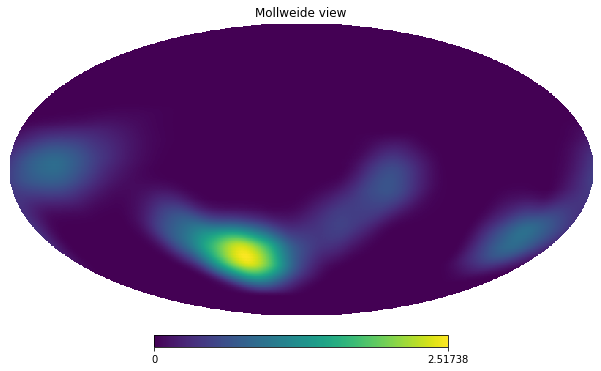

In [52]:
hp.mollview(ninv_patch)

inside cinv_p: nside=2048, 2048
Caching sky fractions...


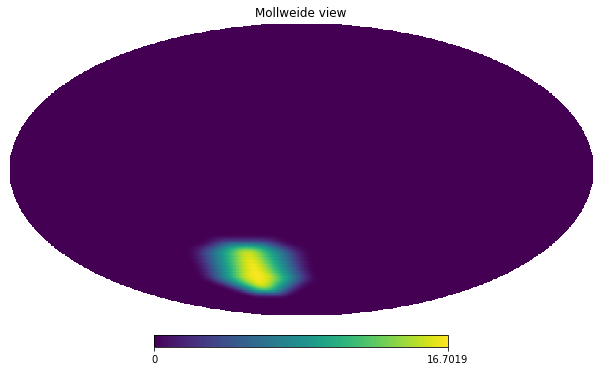

In [54]:
from cmbs4.params.s08b_09 import par_s08b09_cILC_4000 as par_08b
ninv_patch = hp.read_map(par_08b.ivmap_path)
hp.mollview(ninv_patch)

# Check mf

In [32]:
mf = np.load('/global/cscratch1/sd/sebibel/cmbs4/s08d/cILC_00_nozboundslen/iterator_p_p_0000_OBD/mf.npy')

In [39]:
mf_map = hp.alm2map(mf, nside=2048)
mf_map_bp = hp.alm2map(bandpass_alms(mf,2,200), nside=2048)

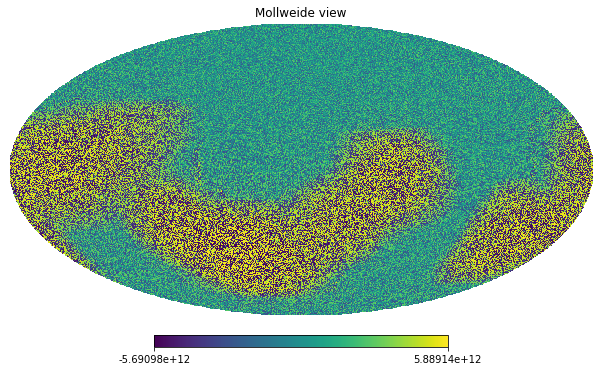

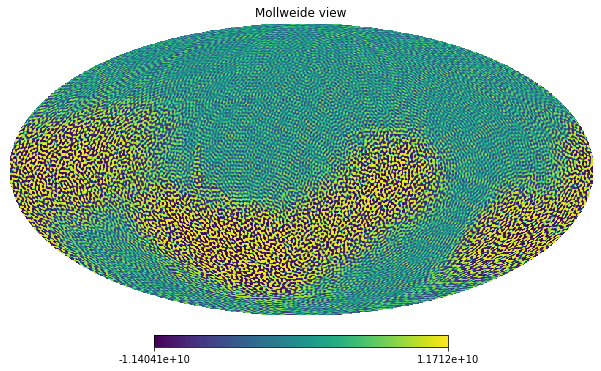

In [40]:
hp.mollview(mf_map, norm='hist')
hp.mollview(mf_map_bp, norm='hist')

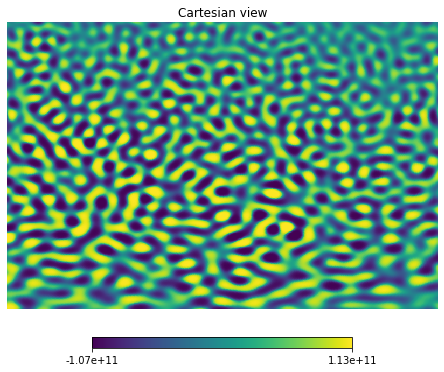

In [68]:
hp.cartview(mf_map_bp, norm='hist', lonra=lonra, latra=latra)

In [71]:
mf_map_bp2 = hp.alm2map(bandpass_alms(mf,150,200), nside=2048)

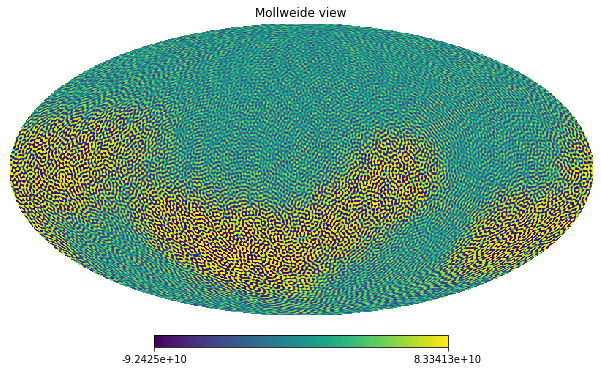

In [72]:
hp.mollview(mf_map_bp2, norm='hist')

(0.0, 200.0)

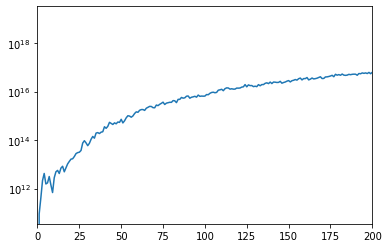

In [80]:
plt.plot(hp.alm2cl(mf))
plt.yscale('log')
plt.xlim(0,200)